# Supervised Learning Fraud Detection

The goal of this project is to use supervised machine learning models to predict whether a bank transaction is fraudulent or not. This problem is a binary classification problem: fraudulent or not fraudulent. Accurate Fraud detection is very important for businesses and individuals. From a business side accurately predicting fraud can help prevent extensive financial loss and prevent a bad reputation. From an individual standpoint it can warn users if potential fraudulent activity happened on their account and help them recover losses from fraudulent transactions. We will look at SVM, Random Forests, and Logistic Regression and compare their performance in predicting fraud.

# Data

The data set we are using for this project is from kaggle and can be found here: https://www.kaggle.com/datasets/ealaxi/paysim1?resource=download 
The dataset is a synthetic data financial transaction dataset labeled with whether the transaction is fraudulent or not. Since financial transactions are normally private a synthetic dataset simulating financial transactions was created. 
Columns of dataset:
- Step: what hour the transaction was simulated in
- Type: The type of transaction whether it was a payment, transfer, cash out, ect
- Amount: currency amount in transaction
- nameOrig: id of account currency came from
- oldbalanceOrig: Balance of account transaction came from before transaction
- newbalanceOrig: Balance of account transaction came from after transaction
- nameDest: id of account the currency is going to
- oldbalanceDest: Balance of account transaction went to before transaction
- newbalanceDest: Balance of account transaction went to after transaction
- isFraud: 0 indicating not fraud, 1 indicating fraud  

The dataset includes 6,362,620 fincial transactions

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
data = pd.read_csv('data/transactions.csv')
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
rows = data.shape[0]
print("Number of rows:", rows)

Number of rows: 6362620


In [4]:
selected_columns = ['type', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud']
data = data[selected_columns]
print(data.head())

       type    amount  oldbalanceOrg  oldbalanceDest  isFraud
0   PAYMENT   9839.64       170136.0             0.0        0
1   PAYMENT   1864.28        21249.0             0.0        0
2  TRANSFER    181.00          181.0             0.0        1
3  CASH_OUT    181.00          181.0         21182.0        1
4   PAYMENT  11668.14        41554.0             0.0        0


In [5]:
data = pd.get_dummies(data, columns=['type'])
data.head()

,amount,oldbalanceOrg,oldbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,170136.0,0.0,0,0,0,0,1,0
1,1864.28,21249.0,0.0,0,0,0,0,1,0
2,181.00,181.0,0.0,1,0,0,0,0,1
3,181.00,181.0,21182.0,1,0,1,0,0,0
4,11668.14,41554.0,0.0,0,0,0,0,1,0


Getting rid of both the new balance columns because they include redundant data with the old balance and transaction amount. Step is not useful so we are removing that column. IdFraudFlagged is removed also because we only care wether it is fraud or not. Getting rid of the id columns also because they do not add useful information to wether it is fraud or not unless we could acces when the account was created or which accounts may be associated with fraud, this could be something we explore later with a dataset that includes when the account was created. Converted type of transaction into binary columns using one-hot encoding so we can use the categorical data in our models. 

#### corelation matrix

In [8]:
correlation_matrix = data.corr()
print(correlation_matrix)

                  amount  oldbalanceOrg  oldbalanceDest   isFraud  \
amount          1.000000      -0.002762        0.294137  0.076688   
oldbalanceOrg  -0.002762       1.000000        0.066243  0.010154   
oldbalanceDest  0.294137       0.066243        1.000000 -0.005885   
isFraud         0.076688       0.010154       -0.005885  1.000000   
type_CASH_IN   -0.009621       0.506761        0.076105 -0.019089   
type_CASH_OUT  -0.004376      -0.200899        0.086028  0.011256   
type_DEBIT     -0.023379      -0.021450        0.009347 -0.002911   
type_PAYMENT   -0.197444      -0.189486       -0.231455 -0.025697   
type_TRANSFER   0.365896      -0.081593        0.130476  0.053869   

                type_CASH_IN  type_CASH_OUT  type_DEBIT  type_PAYMENT  \
amount             -0.009621      -0.004376   -0.023379     -0.197444   
oldbalanceOrg       0.506761      -0.200899   -0.021450     -0.189486   
oldbalanceDest      0.076105       0.086028    0.009347     -0.231455   
isFraud          

#### Histogram of Transaction amounts:

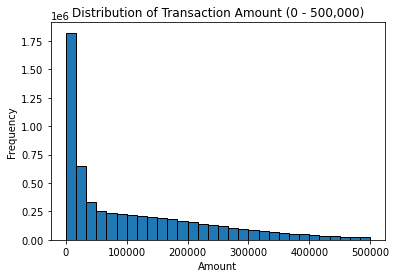

In [15]:
filtered_data = data[(data['amount'] <= 500000)]
plt.hist(filtered_data['amount'], bins=30, edgecolor='black') # remove really high values for histogram
plt.title('Distribution of Transaction Amount (0 - 500,000)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

#### Histogram of Amount for only fraud transactions

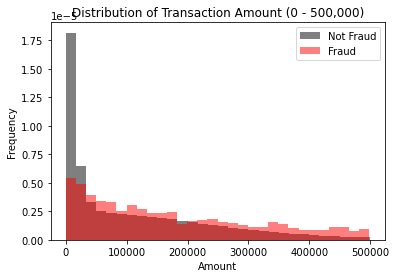

In [24]:
filtered_fraud = filtered_data[(filtered_data['isFraud'] == 1)]
filtered_clean = filtered_data[(filtered_data['isFraud'] == 0)]
plt.hist(filtered_clean['amount'], bins=30, color='black', density=True, alpha=0.5, label = 'Not Fraud')
plt.hist(filtered_fraud['amount'], bins=30, color='red', density=True, alpha =0.5, label = 'Fraud') # remove really high values for histogram
plt.title('Distribution of Transaction Amount (0 - 500,000)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This histogram shows the density histogram of fraud vs not fraud showing fraud transactions tend to be on average higher amount.

#### Histogram of Account Balances Fraud vs Not Fraud:

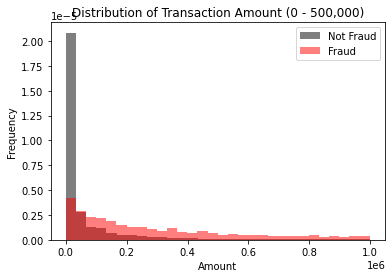

In [26]:
filtered_fraud = data[(data['isFraud'] == 1) & (data['oldbalanceOrg'] <= 1000000)]
filtered_clean = data[(data['isFraud'] == 0) & (data['oldbalanceOrg'] <= 1000000)]
plt.hist(filtered_clean['oldbalanceOrg'], bins=30, color='black', density=True, alpha=0.5, label = 'Not Fraud')
plt.hist(filtered_fraud['oldbalanceOrg'], bins=30, color='red', density=True, alpha =0.5, label = 'Fraud') # remove really high values for histogram
plt.title('Distribution of Transaction Amount (0 - 500,000)')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

This denisty histogram shows fraud tends to happen more on higher valued accounts than no fraud transactions.

# Models

In [42]:
print("Columns:", data.columns)

Columns: Index(['amount', 'oldbalanceOrg', 'oldbalanceDest', 'isFraud', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [6]:
#data split
features = ['amount', 'oldbalanceOrg', 'oldbalanceDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']
target = 'isFraud'
x_train, x_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)


### Logistic Regression

In [9]:
#testing different logistic regression solvers

modelLRlbfgs = LogisticRegression(solver='lbfgs')
modelLRlbfgs.fit(x_train, y_train)

modelLRll = LogisticRegression(solver='liblinear')
modelLRll.fit(x_train, y_train)

#newtons method did not converge so we got rid of it

#removed stochastic gradient descent also because it didn't converge

LogisticRegression(solver='liblinear')

In [10]:
y_pred = modelLRlbfgs.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print('lbfgs solver')
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)


y_pred = modelLRll.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print('Liblinear solver')
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

lbfgs solver
Accuracy: 0.9987395129679283
Confusion Matrix:
[[1270903       1]
 [   1603      17]]
Liblinear solver
Accuracy: 0.9987269395311994
Confusion Matrix:
[[1270904       0]
 [   1620       0]]


The accuracy for both was really high but there was a really low amount of True Positive. The only reason the accuracy was high is because there is a lot less fraud than non-fraud and the models classified almost everything as not fraud. Therefore, despite the high accuracy logistic regression preformed poorly. For fraud detection we are okay with False Positive but missing fraud charges (False Negative) indicates a bad model.

In [35]:
# try changing threshold for lbfgs solver
y_pred_prob = modelLRlbfgs.predict_proba(x_test)[:, 1] 
threshold = 0.0025  # Modify the threshold as needed
y_pred = [1 if prob >= threshold else 0 for prob in y_pred_prob]
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print('lbfgs solver with threshold change')
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

lbfgs solver with threshold change
Accuracy: 0.9010399803854388
Confusion Matrix:
[[1145496  125408]
 [    521    1099]]
Recall: 0.678395061728395


This model despite lower accuracy is an improvement. Even with a threshold change there is still a lot of False Negative which we don't want but it is significantly lower than before. Since we changed the threshold the accuracy decreased and there is a lot of false postives but that is better then before because we want to decrease False negative as much as possible so the accuracy trade off is okay. 
Although this model still isn't great maybe other machine learning algorithms will preform better. We want to get a lower Recall.

### Random Forest

In [12]:

model = RandomForestClassifier(n_estimators=50, max_features='sqrt')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)


Accuracy: 0.9996007933838575
Confusion Matrix:
[[1270814      90]
 [    418    1202]]


In [13]:
#increase estimators
model = RandomForestClassifier(n_estimators=100, max_features='sqrt')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.9996000075440621
Confusion Matrix:
[[1270812      92]
 [    417    1203]]


The Random forest model is preforming significantly better than the logistic regression but we still want to decrease the false negatives. Since the estimator increase didn't help the accuracy we are going to stick with a lower amount of estimators.

In [32]:
model = RandomForestClassifier(n_estimators=50, max_features='sqrt',class_weight='balanced')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.999598435864471
Confusion Matrix:
[[1270802     102]
 [    409    1211]]
Recall: 0.7475308641975309


Similar to Logistic regression to improve the recall we are going to add a threshold.

In [31]:

y_pred_prob = model.predict_proba(x_test)[:, 1]  
threshold = 0.03
y_pred = [1 if prob >= threshold else 0 for prob in y_pred_prob]
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.9976448381327189
Confusion Matrix:
[[1268013    2891]
 [    106    1514]]
Recall: 0.9345679012345679


Adding a threshold greatly increased the Recall while only slightly decreasing the accuracy as mentioned before we want a recall near 1 for this model because we don't want to miss any Fradulent transcations.

In [37]:
model = RandomForestClassifier(n_estimators=50,max_features=None,class_weight='balanced')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.9996220110583376
Confusion Matrix:
[[1270776     128]
 [    353    1267]]
Recall: 0.7820987654320988


In [44]:
y_pred_prob = model.predict_proba(x_test)[:, 1]  
threshold = 0.02
y_pred = [1 if prob >= threshold else 0 for prob in y_pred_prob]
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.9973972985971188
Confusion Matrix:
[[1267632    3272]
 [     40    1580]]
Recall: 0.9753086419753086


By increasing max_Features we were able to get a better recall on similar accuracy.

Overall, Random Forests with some tunig preformed well, as expected significantly better than Logistic Regression.

### SVM

looking at different kernels preformence for Support Vectors

In [8]:
model = SVC(kernel='linear',class_weight='balanced',max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.0032848103454237404
Confusion Matrix:
[[   2561 1268343]
 [      1    1619]]
Recall: 0.9993827160493827


In [9]:
model = SVC(kernel='poly',class_weight='balanced',max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.0012989931820539338
Confusion Matrix:
[[     33 1270871]
 [      0    1620]]
Recall: 1.0


In [10]:
model = SVC(kernel='rbf',class_weight='balanced',max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.0012730604688005885
Confusion Matrix:
[[      0 1270904]
 [      0    1620]]
Recall: 1.0


In [14]:
model = SVC(kernel='sigmoid',class_weight='balanced',max_iter=1000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.0057146269932826415
Confusion Matrix:
[[   5653 1265251]
 [      1    1619]]
Recall: 0.9993827160493827


looking at different values for C.

In [16]:
model = SVC(kernel='sigmoid',class_weight='balanced',max_iter=100,C=0.1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.0014907380921695779
Confusion Matrix:
[[    277 1270627]
 [      0    1620]]
Recall: 1.0


In [17]:
model = SVC(kernel='sigmoid',class_weight='balanced',max_iter=100,C=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.005677692522891513
Confusion Matrix:
[[   5606 1265298]
 [      1    1619]]
Recall: 0.9993827160493827


In [18]:
model = SVC(kernel='sigmoid',class_weight='balanced',max_iter=100,C=20)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.0057122694738959735
Confusion Matrix:
[[   5650 1265254]
 [      1    1619]]
Recall: 0.9993827160493827


In [19]:
model = SVC(kernel='sigmoid',class_weight='balanced',max_iter=2000,C=20)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.0059425205339938576
Confusion Matrix:
[[   5943 1264961]
 [      1    1619]]
Recall: 0.9993827160493827


Feature reduction to help convergence of SVC model

In [24]:
features = ['amount', 'oldbalanceOrg', 'oldbalanceDest']
target = 'isFraud'
x_train, x_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

In [25]:
model = SVC(kernel='linear',class_weight='balanced',max_iter=5000)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.002145342641867658
Confusion Matrix:
[[   1110 1269794]
 [      0    1620]]
Recall: 1.0


In [28]:
model = SVC(kernel='rbf',class_weight='balanced',max_iter=2000,C=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

/Users/blakepeery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.14931034699542012
Confusion Matrix:
[[ 188861 1082043]
 [    480    1140]]
Recall: 0.7037037037037037


# Results

Best Models for each type:
|    Model    |  Accuracy  |   Recall   |
|:-----------:|:----------:|:----------:|
|    Logistic Regression  |   0.901     |   0.678     |
|   Random Forest   |   0.997     |   0.975     |
|   SVM   |   0.149    |   0.704    |

# Conclusion

Out of the methods we explored (SVM, Random Forest, and Logistic Regression) the Random Forest preformed by far the best with 99% aaccuracy and 97% Recall. Tuning the parameters of the Random Forest or trying other Tree Ensemble methods may result in better preformance. The Random Forest may have preformed the best because of its ability to ingnore potential noise in the data (outliers) and irevent features as some of the The SVM overall preformed poorly but I think that was a result of the Max iterations size. The max iteration was put in place because of the lengthy time it took for the SVM to reach convergence. If the SVM model had more time to train it may have reached results as good or better than Random Forests. Based on graphing and looking at the results of Logistic Regression in works well, but more complex models may be better for this problem. Overall, Tree Ensembles look the most promising for predicitng fraud in this dataset and further research should go into the best Tree Ensembles for this problem.